In [1]:
# --- Import data --- #

# Import necessary libraries for data manipulation, modeling, and visualization
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # For saving the model and data
import xgboost as xgb
from xgboost.callback import EarlyStopping # <--- ADD THIS IMPORT

# List the filenames you want to load
filenames = ['cfb-2025-season.csv', 'cfb-2024-season.csv', 'cfb-2023-season.csv', 'cfb-2022-season.csv', 'cfb-2021-season.csv']

# Create an empty list to hold each individual DataFrame
all_dataframes = []

# Loop through the list of filenames
for f in filenames:
    try:
        # Read the current CSV file and append it to the list
        df_temp = pd.read_csv(f)
        all_dataframes.append(df_temp)
        print(f"Successfully loaded {f}")
    except FileNotFoundError:
        print(f"Error: {f} not found. Skipping.")

# Concatenate all the DataFrames in the list into one
# ignore_index=True re-creates the index for the new combined DataFrame
df = pd.concat(all_dataframes, ignore_index=True)

# --- Load SP+ ratings data --- #
# List the filenames for S&P ratings data
sp_filenames = ['sp_ratings_2025.csv','sp_ratings_2024.csv','sp_ratings_2023.csv','sp_ratings_2022.csv','sp_ratings_2021.csv']

# Create an empty list to hold each S&P ratings DataFrame
all_sp_dataframes = []

# Loop through the list of SP filenames
for f in sp_filenames:
    try:
        # Read the current CSV file into a temporary DataFrame and append it
        df_temp = pd.read_csv(f)
        all_sp_dataframes.append(df_temp)
        print(f"Successfully loaded {f}")
    except FileNotFoundError:
        print(f"Error: {f} not found. Skipping.")

# Concatenate all SP ratings DataFrames into a single DataFrame
sp_ratings = pd.concat(all_sp_dataframes, ignore_index=True)
print("Successfully combined all S&P Ratings files.")

# --- Load all game weather data --- #
# List the filenames for weather data
weather_filenames = ['game_weather_2025.csv','game_weather_2024.csv','game_weather_2023.csv','game_weather_2022.csv','game_weather_2021.csv'] # Add more files here like 'game_weather_2024.csv'
all_weather_dataframes = []
for f in weather_filenames:
    try:
        df_temp = pd.read_csv(f)
        all_weather_dataframes.append(df_temp)
        print(f"Successfully loaded {f}")
    except FileNotFoundError:
        print(f"Error: {f} not found. Skipping.")
weather_df = pd.concat(all_weather_dataframes, ignore_index=True)
print("Successfully combined all game weather files.")

# Now 'df' contains the data from all your CSV files
print("\nShape of the combined dataset:", df.shape)
print("\nFirst 5 rows of the combined dataset:")
print(df.head())

Successfully loaded cfb-2025-season.csv
Successfully loaded cfb-2024-season.csv
Successfully loaded cfb-2023-season.csv
Successfully loaded cfb-2022-season.csv
Successfully loaded cfb-2021-season.csv
Successfully loaded sp_ratings_2025.csv
Successfully loaded sp_ratings_2024.csv
Successfully loaded sp_ratings_2023.csv
Successfully loaded sp_ratings_2022.csv
Successfully loaded sp_ratings_2021.csv
Successfully combined all S&P Ratings files.
Successfully loaded game_weather_2025.csv
Successfully loaded game_weather_2024.csv
Successfully loaded game_weather_2023.csv
Successfully loaded game_weather_2022.csv
Successfully loaded game_weather_2021.csv
Successfully combined all game weather files.

Shape of the combined dataset: (5375, 158)

First 5 rows of the combined dataset:
     game_id  season  week season_type                 start_date  completed  \
0  401756846    2025     1     regular  2025-08-23 16:00:00+00:00       True   
1  401767476    2025     1     regular  2025-08-23 17:00

In [2]:
# --- Clean up --- #

# --- Merge SP+ ratings with the main dataframe --- #
# Merge for home teams
df = pd.merge(df, sp_ratings, left_on=['season', 'home_team'], right_on=['year', 'team'], how='left')
df.rename(columns={'sp_rating': 'home_sp_rating', 
                     'off_sp_rating': 'home_off_sp_rating', 
                     'def_sp_rating': 'home_def_sp_rating',
                    'special_sp_rating': 'home_special_sp_rating'}, inplace=True)
df.drop(columns=['year', 'team'], inplace=True)

# Merge for away teams
df = pd.merge(df, sp_ratings, left_on=['season', 'away_team'], right_on=['year', 'team'], how='left')
df.rename(columns={'sp_rating': 'away_sp_rating', 
                     'off_sp_rating': 'away_off_sp_rating', 
                     'def_sp_rating': 'away_def_sp_rating',
                     'special_sp_rating': 'away_special_sp_rating'}, inplace=True)
df.drop(columns=['year', 'team'], inplace=True)

# Define the specific weather features you want to add
features_to_merge = [
    'game_id', 'dewPoint', 'gameIndoors', 'humidity', 'precipitation',
    'pressure', 'snowfall', 'temperature', 'weatherConditionCode', 'windSpeed'
]

# Select only those features from the weather dataframe
weather_features = weather_df[features_to_merge].copy()

# Convert boolean 'gameIndoors' to integer (1 for True, 0 for False)
weather_features['gameIndoors'] = weather_features['gameIndoors'].astype(int)

# Merge the selected weather features into the main dataframe
df = pd.merge(df, weather_features, on='game_id', how='left')

# Convert 'start_date' to a datetime object for chronological sorting
df['start_date'] = pd.to_datetime(df['start_date'])

# Filter for completed games only, as we are training on historical outcomes
df = df[df['completed'] == True].copy()

# Sort the entire dataframe by date. This is CRITICAL for time-series feature engineering.
df.sort_values('start_date', inplace=True)
df.reset_index(drop=True, inplace=True)

# Convert boolean 'conference_game' to integer (1 for True, 0 for False)
df['is_conference_game'] = df['conference_game'].astype(int)

print(f"\nShape of the dataset after cleaning and filtering: {df.shape}")


Shape of the dataset after cleaning and filtering: (5375, 176)


In [3]:
# --- Feature creation with rolling averages --- #

# List of advanced stats to calculate rolling averages for
stats_cols = [
    'off_ppa', 'off_success_rate', 'off_explosiveness',
    'off_passing_ppa', 'off_rushing_ppa',
    'off_passing_success_rate', 'off_rushing_success_rate',
    'def_ppa', 'def_success_rate', 'def_explosiveness',
    'def_passing_ppa', 'def_rushing_ppa',
    'def_passing_success_rate', 'def_rushing_success_rate'
]

# Create new column names for the rolling averages
ewma_cols = [f'{col}_ewma' for col in stats_cols]

# Initialize dictionaries to store the EWMA stats for each team
team_stats_ewma = {}

# Initialize new columns with NaNs
for col in ewma_cols:
    df['home_' + col] = np.nan
    df['away_' + col] = np.nan

# Set the span for the EWMA. A smaller span gives more weight to recent games.
# A span of 5 is a reasonable choice, roughly equivalent to a 5-game moving average.
ewma_span = 5

# Iterate through each game chronologically to calculate pre-game rolling averages
for index, row in df.iterrows():
    home_team = row['home_team']
    away_team = row['away_team']

    # --- Assign Pre-Game Stats ---
    # For the home team
    if home_team in team_stats_ewma:
        for i, stat_col in enumerate(stats_cols):
            df.loc[index, 'home_' + ewma_cols[i]] = team_stats_ewma[home_team][stat_col]
    
    # For the away team
    if away_team in team_stats_ewma:
        for i, stat_col in enumerate(stats_cols):
            df.loc[index, 'away_' + ewma_cols[i]] = team_stats_ewma[away_team][stat_col]

    # --- Update Stats Post-Game ---
    # Update for home team
    if home_team not in team_stats_ewma:
        team_stats_ewma[home_team] = {}
    for stat_col in stats_cols:
        current_val = row['home_' + stat_col]
        if stat_col in team_stats_ewma[home_team]:
            old_ewma = team_stats_ewma[home_team][stat_col]
            new_ewma = pd.Series([old_ewma, current_val]).ewm(span=ewma_span, adjust=False).mean().iloc[-1]
            team_stats_ewma[home_team][stat_col] = new_ewma
        else:
            team_stats_ewma[home_team][stat_col] = current_val

    # Update for away team
    if away_team not in team_stats_ewma:
        team_stats_ewma[away_team] = {}
    for stat_col in stats_cols:
        current_val = row['away_' + stat_col]
        if stat_col in team_stats_ewma[away_team]:
            old_ewma = team_stats_ewma[away_team][stat_col]
            new_ewma = pd.Series([old_ewma, current_val]).ewm(span=ewma_span, adjust=False).mean().iloc[-1]
            team_stats_ewma[away_team][stat_col] = new_ewma
        else:
            team_stats_ewma[away_team][stat_col] = current_val

# Drop rows with NaN values (these are the first games for each team in the dataset)
df.dropna(subset=['home_off_ppa_ewma', 'away_off_ppa_ewma'], inplace=True)
print("\nFeature engineering with rolling averages complete.")
print(f"Shape of dataset after creating EWMA features: {df.shape}")


Feature engineering with rolling averages complete.
Shape of dataset after creating EWMA features: (5194, 204)


In [4]:
# --- Feature finalization with add-ins --- #

# Engineer matchup differential features
df['elo_diff'] = df['home_pregame_elo'] - df['away_pregame_elo']
df['off_ppa_diff'] = df['home_off_ppa_ewma'] - df['away_off_ppa_ewma']
df['def_ppa_diff'] = df['home_def_ppa_ewma'] - df['away_def_ppa_ewma']
df['off_vs_def_success_rate'] = df['home_off_success_rate_ewma'] - df['away_def_success_rate_ewma']
df['away_off_vs_home_def_sr'] = df['away_off_success_rate_ewma'] - df['home_def_success_rate_ewma']
df['pass_off_vs_def_ppa'] = df['home_off_passing_ppa_ewma'] - df['away_def_passing_ppa_ewma']
df['away_pass_off_vs_def_ppa'] = df['away_off_passing_ppa_ewma'] - df['home_def_passing_ppa_ewma']
df['rush_off_vs_def_ppa'] = df['home_off_rushing_ppa_ewma'] - df['away_def_rushing_ppa_ewma']
df['away_rush_off_vs_def_ppa'] = df['away_off_rushing_ppa_ewma'] - df['home_def_rushing_ppa_ewma']
df['explosiveness_diff'] = df['home_off_explosiveness_ewma'] - df['away_off_explosiveness_ewma']

# --- Add SP+ differential features --- #
df['sp_rating_diff'] = df['home_sp_rating'] - df['away_sp_rating']
df['off_sp_rating_diff'] = df['home_off_sp_rating'] - df['away_off_sp_rating']
df['def_sp_rating_diff'] = df['home_def_sp_rating'] - df['away_def_sp_rating']

# --- Add-ins ---
# --- Encode conference columns --- #
# Home Conference
home_conf_dummies = pd.get_dummies(df['home_conference'], prefix='home_conf')
home_conf_feature_names = home_conf_dummies.columns.tolist()
df = pd.concat([df, home_conf_dummies], axis=1)
print(f"Added {len(home_conf_feature_names)} new features from one-hot encoding 'home_conference'.")

# Away Conference
away_conf_dummies = pd.get_dummies(df['away_conference'], prefix='away_conf')
away_conf_feature_names = away_conf_dummies.columns.tolist()
df = pd.concat([df, away_conf_dummies], axis=1)
print(f"Added {len(away_conf_feature_names)} new features from one-hot encoding 'away_conference'.")

# --- Encode venue columns --- #
# Convert the categorical 'venue' column into numerical format
venue_dummies = pd.get_dummies(df['venue'], prefix='venue', drop_first=True)

# --- One-Hot Encode Weather Condition and define weather features --- #
weather_cond_dummies = pd.get_dummies(df['weatherConditionCode'], prefix='weather_cond')
weather_cond_feature_names = weather_cond_dummies.columns.tolist()
df = pd.concat([df, weather_cond_dummies], axis=1)
print(f"Added {len(weather_cond_feature_names)} new features from 'weatherConditionCode'.")

weather_feature_names = [
    'dewPoint', 'gameIndoors', 'humidity', 'precipitation',
    'pressure', 'snowfall', 'temperature', 'windSpeed'
]

# Get the list of the new venue column names
venue_feature_names = venue_dummies.columns.tolist()

# Add the new one-hot encoded columns to the main dataframe
df = pd.concat([df, venue_dummies], axis=1)

print(f"Added {len(venue_feature_names)} new features from one-hot encoding the 'venue' column.")

# Define the final list of features for the model
# This now includes the original features PLUS the new one-hot encoded venue features
features = [
    'elo_diff',
    'off_ppa_diff',
    'def_ppa_diff',
    'off_vs_def_success_rate',
    'away_off_vs_home_def_sr',
    'pass_off_vs_def_ppa',
    'away_pass_off_vs_def_ppa',
    'rush_off_vs_def_ppa',
    'away_rush_off_vs_def_ppa',
    'explosiveness_diff',
    'is_conference_game',
    # New S&P features
    'sp_rating_diff',
    'off_sp_rating_diff',
    'def_sp_rating_diff'
] + venue_feature_names + home_conf_feature_names + away_conf_feature_names + weather_feature_names + weather_cond_feature_names # <-- ADD WEATHER FEATURES

# Define the target variables
targets = ['home_points', 'away_points']

# Create the final feature matrix (X) and target vectors (y)
X = df[features]
y_home = df['home_points']
y_away = df['away_points']

print("\nFinal feature set and target variables created.")
print("Features used for modeling:\n", features)

Added 29 new features from one-hot encoding 'home_conference'.
Added 30 new features from one-hot encoding 'away_conference'.
Added 0 new features from 'weatherConditionCode'.
Added 305 new features from one-hot encoding the 'venue' column.

Final feature set and target variables created.
Features used for modeling:
 ['elo_diff', 'off_ppa_diff', 'def_ppa_diff', 'off_vs_def_success_rate', 'away_off_vs_home_def_sr', 'pass_off_vs_def_ppa', 'away_pass_off_vs_def_ppa', 'rush_off_vs_def_ppa', 'away_rush_off_vs_def_ppa', 'explosiveness_diff', 'is_conference_game', 'sp_rating_diff', 'off_sp_rating_diff', 'def_sp_rating_diff', 'venue_Ace W. Mumford Stadium', 'venue_Acrisure Stadium', 'venue_Aggie Memorial Stadium', 'venue_Aggie Stadium', 'venue_Alamodome', 'venue_Albertsons Stadium', 'venue_Alerus Center', 'venue_Alex G. Spanos Stadium', 'venue_Alfond Stadium', 'venue_Allegacy Federal Credit Union Stadium', 'venue_Allegiant Stadium', 'venue_Allen E. Paulson Stadium', 'venue_Aloha Stadium', 'ven


Training set size: 4155
Test set size: 1039

Home Points Model Evaluation:
RMSE: 12.3560
R-squared: 0.2568

Away Points Model Evaluation:
RMSE: 10.9822
R-squared: 0.2639


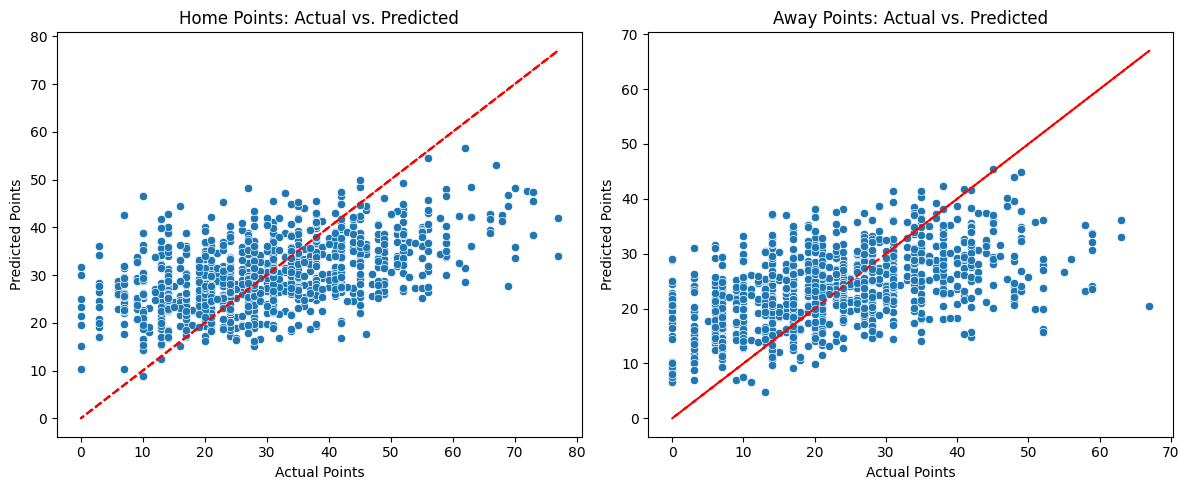

In [5]:
# --- Train & Test --- #

# Chronological train-test split to simulate real-world prediction
# We will use the last 20% of the data as our test set
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_home_train, y_home_test = y_home[:split_index], y_home[split_index:]
y_away_train, y_away_test = y_away[:split_index], y_away[split_index:]

print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# --- Train Home Points Model ---
xgb_home = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=50,
)
xgb_home.fit(X_train, y_home_train, 
             eval_set=[(X_test, y_home_test)], 
             verbose=False)

# --- Train Away Points Model ---
xgb_away = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=50,
)
xgb_away.fit(X_train, y_away_train, 
             eval_set=[(X_test, y_away_test)], 
             verbose=False)

# --- Make Predictions ---
home_preds = xgb_home.predict(X_test)
away_preds = xgb_away.predict(X_test)

# --- Evaluate Models ---
home_rmse = np.sqrt(mean_squared_error(y_home_test, home_preds))
home_r2 = r2_score(y_home_test, home_preds)
away_rmse = np.sqrt(mean_squared_error(y_away_test, away_preds))
away_r2 = r2_score(y_away_test, away_preds)

print("\nHome Points Model Evaluation:")
print(f"RMSE: {home_rmse:.4f}")
print(f"R-squared: {home_r2:.4f}")

print("\nAway Points Model Evaluation:")
print(f"RMSE: {away_rmse:.4f}")
print(f"R-squared: {away_r2:.4f}")

# Visualize predictions vs actuals
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_home_test, y=home_preds)
plt.plot(y_home_test, y_home_test, color='red', linestyle='--') 
plt.title('Home Points: Actual vs. Predicted')
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_away_test, y=away_preds)
plt.plot(y_away_test, y_away_test, color='red', linestyle='--')
plt.title('Away Points: Actual vs. Predicted')
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')
plt.tight_layout()
plt.show()

In [6]:
# --- Combined Team Performance Analysis ---

# 1. Create a results DataFrame with predictions (Prerequisite from previous cell)
results_df = df.iloc[split_index:].copy()
results_df['actual_home_pts'] = y_home_test.values
results_df['predicted_home_pts'] = home_preds
results_df['actual_away_pts'] = y_away_test.values
results_df['predicted_away_pts'] = away_preds

# 2. Calculate Prediction Accuracy Metrics
results_df['home_error'] = abs(results_df['actual_home_pts'] - results_df['predicted_home_pts'])
results_df['away_error'] = abs(results_df['actual_away_pts'] - results_df['predicted_away_pts'])

home_errors = results_df[['home_team', 'home_error']].rename(columns={'home_team': 'team', 'home_error': 'error'})
away_errors = results_df[['away_team', 'away_error']].rename(columns={'away_team': 'team', 'away_error': 'error'})
all_team_errors = pd.concat([home_errors, away_errors], ignore_index=True)

team_accuracy_summary = all_team_errors.groupby('team')['error'].agg(
    average_prediction_error='mean',
    games_played='count'
).reset_index()

# 3. Calculate Improvement vs. Betting Lines Metrics
results_df['actual_total'] = results_df['actual_home_pts'] + results_df['actual_away_pts']
results_df['actual_spread'] = results_df['actual_home_pts'] - results_df['actual_away_pts']
results_df['predicted_total'] = results_df['predicted_home_pts'] + results_df['predicted_away_pts']
results_df['predicted_spread'] = results_df['predicted_home_pts'] - results_df['predicted_away_pts']

results_df['model_total_error'] = abs(results_df['predicted_total'] - results_df['actual_total'])
results_df['model_spread_error'] = abs(results_df['predicted_spread'] - results_df['actual_spread'])

results_df['avg_bookie_total_error'] = results_df[['espn_over_under', 'draftkings_over_under', 'bovada_over_under']].sub(results_df['actual_total'], axis=0).abs().mean(axis=1)
results_df['avg_bookie_spread_error'] = results_df[['espn_spread', 'draftkings_spread', 'bovada_spread']].sub(results_df['actual_spread'], axis=0).abs().mean(axis=1)

results_df['improvement_vs_total'] = results_df['avg_bookie_total_error'] - results_df['model_total_error']
results_df['improvement_vs_spread'] = results_df['avg_bookie_spread_error'] - results_df['model_spread_error']

home_improvement = results_df[['home_team', 'improvement_vs_total', 'improvement_vs_spread']].rename(columns={'home_team': 'team'})
away_improvement = results_df[['away_team', 'improvement_vs_total', 'improvement_vs_spread']].rename(columns={'away_team': 'team'})
all_team_improvement = pd.concat([home_improvement, away_improvement], ignore_index=True)

team_improvement_summary = all_team_improvement.groupby('team').agg(
    avg_improvement_vs_total=('improvement_vs_total', 'mean'),
    avg_improvement_vs_spread=('improvement_vs_spread', 'mean')
).reset_index()
team_improvement_summary['combined_improvement'] = team_improvement_summary['avg_improvement_vs_total'] + team_improvement_summary['avg_improvement_vs_spread']

# 4. Merge accuracy and improvement summaries into one DataFrame
combined_summary_df = pd.merge(team_accuracy_summary, team_improvement_summary, on='team')

# 5. Sort the full DataFrame for the CSV output (most accurate, then most improved)
combined_summary_df_sorted = combined_summary_df.sort_values(
    by=['average_prediction_error', 'combined_improvement'], 
    ascending=[True, False]
)

# 6. Save the FULL sorted list to a CSV file
output_filename = 'all_teams_performance_summary.csv'
# Reorder columns for a cleaner CSV layout
csv_columns = [
    'team', 'games_played', 'average_prediction_error', 
    'combined_improvement', 'avg_improvement_vs_spread', 'avg_improvement_vs_total'
]
combined_summary_df_sorted[csv_columns].round(2).to_csv(output_filename, index=False)
print(f"Full performance summary for all teams saved to '{output_filename}'")

# 7. Print the Top 5 most accurate teams to the cell
print("\n--- Most Accurately Predicted Teams (On Average) ---")
print("(Based on the lowest average score prediction error in the test set)")
print(combined_summary_df_sorted[csv_columns].round(2).to_string(index=False))

# 8. Print the Top 5 most improved teams vs. bookies to the cell
print("\n--- Top Teams: Model's Average Improvement Over Betting Lines ---")
print("(Positive values indicate the model was more accurate than the average bookie line)")
print(combined_summary_df[csv_columns].round(2).to_string(index=False))

Full performance summary for all teams saved to 'all_teams_performance_summary.csv'

--- Most Accurately Predicted Teams (On Average) ---
(Based on the lowest average score prediction error in the test set)
                    team  games_played  average_prediction_error  combined_improvement  avg_improvement_vs_spread  avg_improvement_vs_total
              Mercyhurst             4                      2.91                 17.16                      16.34                      0.82
     Central Connecticut             7                      3.35                  9.36                      11.34                     -1.98
               Grambling             7                      3.49                 21.34                      20.02                      1.32
               UL Monroe             8                      3.54                 35.37                      30.96                      4.41
                  Towson             7                      3.65                  5.51       

In [7]:
# --- Predicting Future Games ---

print("--- Starting Week Predictions ---")

# 1. Load the new data for the week you want to predict
try:
    df_future = pd.read_csv('cfb-2025-week3-predictions-empty.csv')
    print(f"Successfully loaded {len(df_future)} future games to predict.")
except FileNotFoundError:
    print("Error: 'cfb-2025-week3-predictions-empty.csv' not found. Please make sure the file is in the correct directory.")

# 2. Replicate the feature engineering process on the new data
# Basic preprocessing
df_future['is_conference_game'] = df_future['conference_game'].astype(int)

# Initialize the EWMA columns
stats_cols = [
    'off_ppa', 'off_success_rate', 'off_explosiveness', 'off_passing_ppa', 'off_rushing_ppa',
    'off_passing_success_rate', 'off_rushing_success_rate', 'def_ppa', 'def_success_rate',
    'def_explosiveness', 'def_passing_ppa', 'def_rushing_ppa', 'def_passing_success_rate', 'def_rushing_success_rate'
]
ewma_cols = [f'{col}_ewma' for col in stats_cols]
for col in ewma_cols:
    df_future['home_' + col] = np.nan
    df_future['away_' + col] = np.nan

# Assign the final EWMA values from the 'team_stats_ewma' dictionary already in memory
for index, row in df_future.iterrows():
    home_team = row['home_team']
    away_team = row['away_team']

    home_team_latest_stats = team_stats_ewma.get(home_team, {})
    away_team_latest_stats = team_stats_ewma.get(away_team, {})

    for i, stat_col in enumerate(stats_cols):
        df_future.loc[index, 'home_' + ewma_cols[i]] = home_team_latest_stats.get(stat_col)
        df_future.loc[index, 'away_' + ewma_cols[i]] = away_team_latest_stats.get(stat_col)

# --- Add SP ratings to the future games data --- #
# Merge SP ratings for home teams, matching on the game's season and team name
df_future = pd.merge(df_future, sp_ratings, left_on=['season', 'home_team'], right_on=['year', 'team'], how='left')
df_future.rename(columns={'sp_rating': 'home_sp_rating',
                           'off_sp_rating': 'home_off_sp_rating',
                           'def_sp_rating': 'home_def_sp_rating',
                           'special_sp_rating': 'home_special_sp_rating'}, inplace=True)
df_future.drop(columns=['year', 'team'], inplace=True)

# Merge SP ratings for away teams, matching on the game's season and team name
df_future = pd.merge(df_future, sp_ratings, left_on=['season', 'away_team'], right_on=['year', 'team'], how='left')
df_future.rename(columns={'sp_rating': 'away_sp_rating',
                           'off_sp_rating': 'away_off_sp_rating',
                           'def_sp_rating': 'away_def_sp_rating',
                           'special_sp_rating': 'away_special_sp_rating'}, inplace=True)
df_future.drop(columns=['year', 'team'], inplace=True)

# --- Add weather data to future games --- #
df_future = pd.merge(df_future, weather_features, on='game_id', how='left')

# --- One-Hot Encode Venue for future data ---
future_venue_dummies = pd.get_dummies(df_future['venue'], prefix='venue', drop_first=True)
# Reindex to match the columns from the training data, filling missing columns with 0
future_venue_dummies = future_venue_dummies.reindex(columns=venue_feature_names, fill_value=0)
df_future = pd.concat([df_future, future_venue_dummies], axis=1)

# --- One-Hot Encode conference for future data --- #
# Home Conference
future_home_conf_dummies = pd.get_dummies(df_future['home_conference'], prefix='home_conf')
future_home_conf_dummies = future_home_conf_dummies.reindex(columns=home_conf_feature_names, fill_value=0)
df_future = pd.concat([df_future, future_home_conf_dummies], axis=1)

# Away Conference
future_away_conf_dummies = pd.get_dummies(df_future['away_conference'], prefix='away_conf')
future_away_conf_dummies = future_away_conf_dummies.reindex(columns=away_conf_feature_names, fill_value=0)
df_future = pd.concat([df_future, future_away_conf_dummies], axis=1)

# --- One-hot encode weather condition for future games --- #
future_weather_cond_dummies = pd.get_dummies(df_future['weatherConditionCode'], prefix='weather_cond')
future_weather_cond_dummies = future_weather_cond_dummies.reindex(columns=weather_cond_feature_names, fill_value=0)
df_future = pd.concat([df_future, future_weather_cond_dummies], axis=1)

# Create the final differential features
df_future['elo_diff'] = df_future['home_pregame_elo'] - df_future['away_pregame_elo']
df_future['off_ppa_diff'] = df_future['home_off_ppa_ewma'] - df_future['away_off_ppa_ewma']
df_future['def_ppa_diff'] = df_future['home_def_ppa_ewma'] - df_future['away_def_ppa_ewma']
df_future['off_vs_def_success_rate'] = df_future['home_off_success_rate_ewma'] - df_future['away_def_success_rate_ewma']
df_future['away_off_vs_home_def_sr'] = df_future['away_off_success_rate_ewma'] - df_future['home_def_success_rate_ewma']
df_future['pass_off_vs_def_ppa'] = df_future['home_off_passing_ppa_ewma'] - df_future['away_def_passing_ppa_ewma']
df_future['away_pass_off_vs_def_ppa'] = df_future['away_off_passing_ppa_ewma'] - df_future['home_def_passing_ppa_ewma']
df_future['rush_off_vs_def_ppa'] = df_future['home_off_rushing_ppa_ewma'] - df_future['away_def_rushing_ppa_ewma']
df_future['away_rush_off_vs_def_ppa'] = df_future['away_off_rushing_ppa_ewma'] - df_future['home_def_rushing_ppa_ewma']
df_future['explosiveness_diff'] = df_future['home_off_explosiveness_ewma'] - df_future['away_off_explosiveness_ewma']

# --- Create SP differential features for future games --- #
df_future['sp_rating_diff'] = df_future['home_sp_rating'] - df_future['away_sp_rating']
df_future['off_sp_rating_diff'] = df_future['home_off_sp_rating'] - df_future['away_off_sp_rating']
df_future['def_sp_rating_diff'] = df_future['home_def_sp_rating'] - df_future['away_def_sp_rating']

# 3. Create the feature matrix using the 'features' list already in memory
X_future = df_future[features].copy()

# Handle any potential missing values (e.g., for new teams not in training data) by filling with 0
X_future.fillna(0, inplace=True)

# 4. Make predictions using the 'xgb_home' and 'xgb_away' models already in memory
future_home_preds = xgb_home.predict(X_future)
future_away_preds = xgb_away.predict(X_future)

# 5. Create the results DataFrame
predictions_df = pd.DataFrame({
    'Home_Team': df_future['home_team'],
    'Away_Team': df_future['away_team'],
    'Predicted_Home_Points': future_home_preds.round(1),
    'Predicted_Away_Points': future_away_preds.round(1)
})

# 6. Calculate historical game counts and add them to the predictions DataFrame
# This uses the main historical 'df' which is already in memory
home_games = df['home_team'].value_counts()
away_games = df['away_team'].value_counts()
historical_game_counts = home_games.add(away_games, fill_value=0).astype(int)

# Map the counts to the home and away teams in our predictions
predictions_df['Home_Team_Games'] = predictions_df['Home_Team'].map(historical_game_counts).fillna(0).astype(int)
predictions_df['Away_Team_Games'] = predictions_df['Away_Team'].map(historical_game_counts).fillna(0).astype(int)

# 7. Display the final results
print("\n--- Week Predictions with Historical Game Counts ---")
# Using .to_string() to ensure all rows are printed
print(predictions_df.to_string(index=False))

# 8. Save the detailed comparison to a CSV file
allpicks_output_filename_detailed = 'cfb_week3_all_predictions.csv'
predictions_df.round(2).to_csv(allpicks_output_filename_detailed, index=False)

--- Starting Week Predictions ---
Successfully loaded 294 future games to predict.

--- Week Predictions with Historical Game Counts ---
                    Home_Team                       Away_Team  Predicted_Home_Points  Predicted_Away_Points  Home_Team_Games  Away_Team_Games
       West Virginia Wesleyan                  Ohio Dominican              29.799999              24.700001                0                0
                  Wake Forest                        NC State              26.600000              28.200001               53               52
                Clark Atlanta               Fort Valley State              28.100000              26.200001                0                0
           Harding University     Southwestern Oklahoma State              28.100000              26.200001                0                0
             Central Missouri                      CSU Pueblo              29.799999              24.700001                0                0
           

In [8]:
# --- Comparing Predictions to Betting Lines (Detailed View with Game Counts) ---

# 1. Combine predictions with the future game data which contains the betting lines
comparison_df = df_future.copy()
comparison_df['predicted_home_pts'] = predictions_df['Predicted_Home_Points']
comparison_df['predicted_away_pts'] = predictions_df['Predicted_Away_Points']

# 2. Calculate the model's predicted total and spread
comparison_df['predicted_total'] = comparison_df['predicted_home_pts'] + comparison_df['predicted_away_pts']
comparison_df['predicted_spread'] = comparison_df['predicted_away_pts'] - comparison_df['predicted_home_pts']

# 3. Calculate the average betting line for spread and over/under
spread_cols = ['espn_spread', 'draftkings_spread', 'bovada_spread']
over_under_cols = ['espn_over_under', 'draftkings_over_under', 'bovada_over_under']

comparison_df['avg_line_spread'] = comparison_df[spread_cols].mean(axis=1)
comparison_df['avg_line_over_under'] = comparison_df[over_under_cols].mean(axis=1)

# 4. Calculate the absolute difference between the model's prediction and the betting lines
comparison_df['spread_difference'] = abs(comparison_df['predicted_spread'] - comparison_df['avg_line_spread'])
comparison_df['total_difference'] = abs(comparison_df['predicted_total'] - comparison_df['avg_line_over_under'])

# 5. Create a combined difference score to rank the biggest disagreements
comparison_df['combined_difference'] = comparison_df['spread_difference'] + comparison_df['total_difference']

# 6. Filter out games that don't have any betting line data
final_comparison = comparison_df.dropna(subset=['avg_line_spread', 'avg_line_over_under']).copy()

# 7. Sort by the biggest combined difference
top_differences = final_comparison.sort_values(by='combined_difference', ascending=False)

# 8. NEW: Calculate historical game counts and add them to the table
# This uses the main historical 'df' which is already in memory
home_games = df['home_team'].value_counts()
away_games = df['away_team'].value_counts()
historical_game_counts = home_games.add(away_games, fill_value=0).astype(int)

# Map the counts to the home and away teams in our list
top_differences['home_team_games_played'] = top_differences['home_team'].map(historical_game_counts).fillna(0).astype(int)
top_differences['away_team_games_played'] = top_differences['away_team'].map(historical_game_counts).fillna(0).astype(int)


# 9. Create a new, more detailed list of columns for the output
output_columns_detailed = [
    'home_team',
    'home_team_games_played', # New Column
    'away_team',
    'away_team_games_played', # New Column
    # Model Predictions
    'predicted_spread',
    'predicted_total',
    # Individual Spreads
    'espn_spread',
    'draftkings_spread',
    'bovada_spread',
    # Individual Over/Under
    'espn_over_under',
    'draftkings_over_under',
    'bovada_over_under',
    # Difference Metrics
    'spread_difference',
    'total_difference',
    'combined_difference'
]

# Display the results
print("\n--- Biggest Differences Between Model Predictions and Individual Betting Lines ---")
print(top_differences[output_columns_detailed].round(2).to_string(index=False));

# 10. Save the detailed comparison to a CSV file
comparison_output_filename_detailed = 'cfb_week3_prediction_vs_lines.csv'
top_differences[output_columns_detailed].round(2).to_csv(comparison_output_filename_detailed, index=False)

print(f"\nDetailed comparison saved to '{comparison_output_filename_detailed}'")


--- Biggest Differences Between Model Predictions and Individual Betting Lines ---
            home_team  home_team_games_played          away_team  away_team_games_played  predicted_spread  predicted_total  espn_spread  draftkings_spread  bovada_spread  espn_over_under  draftkings_over_under  bovada_over_under  spread_difference  total_difference  combined_difference
       Louisiana Tech                      49   New Mexico State                      51         -2.000000        54.400002         -9.5                NaN           -9.5             42.5                    NaN               43.0               7.50             11.65                19.15
            Tennessee                      52            Georgia                      59         -7.800000        54.799999          7.0                7.5            5.0             50.5                   50.5               49.5              14.30              4.63                18.93
           California                      50       

In [9]:
# --- Calculate Pick Score ---

import pandas as pd

# Load the detailed comparison and performance summary files created by previous cells
detailed_comparison = pd.read_csv('cfb_week3_prediction_vs_lines.csv')
performance_summary = pd.read_csv('all_teams_performance_summary.csv')

# --- Combine Game Differences with Team Performance ---

# Merge the performance data for the home team
# We add 'home_' as a prefix to performance columns to avoid name conflicts
home_performance = performance_summary.add_prefix('home_')
merged_data = pd.merge(detailed_comparison, home_performance, left_on='home_team', right_on='home_team', how='left')

# Merge the performance data for the away team
# We add 'away_' as a prefix for the same reason
away_performance = performance_summary.add_prefix('away_')
merged_data = pd.merge(merged_data, away_performance, left_on='away_team', right_on='away_team', how='left')

# --- Calculate the Pick Score ---

# Create a composite "pick_score" to rank the best opportunities.
# This score is higher for games with a large difference between your model and the bookies,
# and for games where your model has historically been more accurate (lower average prediction error).
# We add 1 to the denominator to prevent division-by-zero errors.
merged_data['pick_score'] = merged_data['combined_difference'] / (merged_data['home_average_prediction_error'] + merged_data['away_average_prediction_error'] + 1)

# Sort the DataFrame by the new pick_score in descending order to find the top picks
best_picks = merged_data.sort_values(by='pick_score', ascending=False)

# --- Display and Save the Results ---

# Select and reorder the most relevant columns for a clean output
output_columns = [
    'home_team',
    'away_team',
    'predicted_spread',
    'espn_spread',
    'draftkings_spread',
    'bovada_spread',
    'predicted_total',
    'espn_over_under',
    'draftkings_over_under',
    'bovada_over_under',
    'combined_difference',
    'home_average_prediction_error',
    'away_average_prediction_error',
    'pick_score'
]

best_picks_output = best_picks[output_columns].round(2)

# Save the full ranked list of potential picks to a new CSV file
best_picks_output.to_csv('best_potential_picks.csv', index=False)

# Print the top 20 best potential picks directly in the notebook for quick analysis
print("--- Top 20 Best Potential Picks ---")
print("(Ranked by a score combining model/bookie difference and historical model accuracy)")
print(best_picks_output.head(20).to_string(index=False))

print("\n\n'best_potential_picks.csv' has been created with the full ranked list.")

--- Top 20 Best Potential Picks ---
(Ranked by a score combining model/bookie difference and historical model accuracy)
     home_team        away_team  predicted_spread  espn_spread  draftkings_spread  bovada_spread  predicted_total  espn_over_under  draftkings_over_under  bovada_over_under  combined_difference  home_average_prediction_error  away_average_prediction_error  pick_score
     Tennessee          Georgia              -7.8          7.0                7.5            5.0             54.8             50.5                   50.5               49.5                18.93                           8.50                           7.63        1.11
Louisiana Tech New Mexico State              -2.0         -9.5                NaN           -9.5             54.4             42.5                    NaN               43.0                19.15                           9.66                           8.15        1.02
       Houston         Colorado              -3.3         -4.5              